<h1 style="color:rgba(255,100,245,0.5);text-align:center"><u>Overview</u></h1>

In this notebook we'll explore the historical stock price for Apple. I'm curious to know how Apple has progressed over the years and thought this would be the perfect time to investigate. This being a time series project will explore different algorithms that can be used to predict share price which include the following models:

  * ARIMA
  * Auto-ARIMA
  * Simple Exponential Smoothing
  * Holt's (aka Double Exponential Smoothing)
  * RNN, GRU and LSTM 

Before we make use of the above models, we first clean the data into a more appropriate format, followed by some interactive exploratory data analysis.

The data for this notebook has been gathered from Yahoo Finance and is available on the below link:
https://finance.yahoo.com/quote/AAPL/history?period1=345513600&period2=1617580800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true 

<h1 style="color:rgba(244,10,10,0.6);text-align:center"><u>Ingesting, Cleaning and Fixing the Data</u></h1>

<h3>Load Packages</h3>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
import tensorflow as tf
import plotly.express as px
import plotly.graph_objects as go # for line plot with nodes
import seaborn as sns
import math
import pmdarima as pm

from IPython.display import display, HTML
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs # test for optimal number of differencing in ARIMA 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from tensorflow.keras import Model
from keras.layers import Dense, Dropout, LSTM, SimpleRNN, GRU
from sklearn.preprocessing import MinMaxScaler

<h3>Styling Options</h3>

In [2]:
# Put Dataframes side by side
css = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

<h3>Importing and Inspecting the Data</h3>

In [3]:
df_stocks = pd.read_csv("data/AAPL.csv")
df_divs = pd.read_csv("data/AAPL-dividends.csv")
df_splits = pd.read_csv("data/AAPL-stockSplits.csv")

df_all_3 = [df_stocks, df_divs, df_splits]

In [4]:
for df in df_all_3:
    display(df.head())

Date      Open      High       Low     Close  Adj Close       Volume
0  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.095657  175884800.0
1  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.088636  105728000.0
2  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090830   86441600.0
3  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.093463   73449600.0
4  1980-12-19  0.126116  0.126674  0.126116  0.126116   0.099167   48630400.0

Date  Dividends
0  1993-11-19   0.001071
1  1989-11-17   0.000982
2  2018-11-08   0.182500
3  2019-05-10   0.192500
4  1990-05-21   0.000982

Date Stock Splits
0  2000-06-21          2:1
1  2005-02-28          2:1
2  2020-08-31          4:1
3  1987-06-16          2:1
4  2014-06-09          7:1

In [5]:
display(df_stocks.describe())
display(df_divs.describe())

Open          High           Low         Close     Adj Close  \
count  10160.000000  10160.000000  10160.000000  10160.000000  10160.000000   
mean      10.653717     10.768866     10.534321     10.655391     10.092712   
std       21.563366     21.813455     21.294331     21.562111     21.241777   
min        0.049665      0.049665      0.049107      0.049107      0.038614   
25%        0.274554      0.281250      0.267299      0.273438      0.231146   
50%        0.446429      0.454821      0.437768      0.446607      0.373080   
75%       11.999107     12.084464     11.887232     12.003750     10.339591   
max      143.600006    145.089996    141.369995    143.160004    142.946396   

             Volume  
count  1.016000e+04  
mean   3.381602e+08  
std    3.412373e+08  
min    1.388800e+06  
25%    1.298688e+08  
50%    2.259740e+08  
75%    4.201904e+08  
max    7.421641e+09

Dividends
count  70.000000
mean    0.075194
std     0.079071
min     0.000536
25%     0.001071
50%     0.047857
75%     0.142500
max     0.205000

In [6]:
for df in df_all_3:
    df.info()
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10161 entries, 0 to 10160
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10161 non-null  object 
 1   Open       10160 non-null  float64
 2   High       10160 non-null  float64
 3   Low        10160 non-null  float64
 4   Close      10160 non-null  float64
 5   Adj Close  10160 non-null  float64
 6   Volume     10160 non-null  float64
dtypes: float64(6), object(1)
memory usage: 555.8+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       70 non-null     object 
 1   Dividends  70 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------       

There seems to be 1 missing value in the stocks df for all columns, except Date. We'll handle this in the next section.

<h3>Handling Missing Values</h3>

In [7]:
# Checking missing values 
def missing_values(df):
    global df_mv_cols
    mv = df.isnull().sum().sort_values(ascending=False)
    percentage = round(mv / len(df) * 100, 2)   # rounded 2 dp
    df_mv = pd.concat([mv, percentage], axis=1, keys=['Total', 'Percentage'])
    if sum(mv) > 0:
        return df_mv.loc[df_mv['Total'] > 0]
    else:
        return "No Missing Values"

for df in df_all_3:
    print(f'{missing_values(df)}\n')

           Total  Percentage
Open           1        0.01
High           1        0.01
Low            1        0.01
Close          1        0.01
Adj Close      1        0.01
Volume         1        0.01

No Missing Values

No Missing Values



In [8]:
# Inspecting missing values
df_stocks.loc[df_stocks.isnull().any(axis=1)]

Date  Open  High  Low  Close  Adj Close  Volume
164  1981-08-10   NaN   NaN  NaN    NaN        NaN     NaN

In [9]:
# Dropping the above row from the data
df_stocks.dropna(inplace=True)

<h1 style="color:rgba(100,150,250,0.6);text-align:center"><u>Exploratory Data Analysis</u></h1>

<h3>Stock Price Since Initial Listing</h3>

In [10]:
fig = px.line(df_stocks, 
              x='Date', 
              y='Close', 
              title='Apple Share Price',
              width=950)

fig.update_layout(title_x=0.5)

fig.show()

Back in December 1980 the share price was only about 15.8 cents. Comparing this with the most recent price of \\$121.39, this is over a 76700% increase in stock price, WOW! To put this into perspective, if you were to invest \$1,000 back in December 1980, that \\$1,000 worth of stock would now be valued at over \\$767,000. Though, it wasn't until around 2004-2005 did the stock price start to increase quite rapidly, mostly attributable to the release of the first Ipod. That means, to see any significant rise in stock value, you would of had to wait 25 years since 1980, quite a wait, but definitely worth it now.

<h3>Stock Price Last 1000 Trading Days</h3>

In [11]:
# The graph can only handle 1000 values, otherwise it'll look blurry and the rangeselector won't show any lines
fig = px.line(df_stocks[-1000:], 
              x='Date', 
              y='Close', 
              title='Apple Share Price Past 1000 Values',
              width=950)

fig.update_layout(title_x=0.5)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

Approximately across a 4 year period the stock price has significantly risen from ~\\$35 to ~\\$121 reaching as high as ~\\$143 in January 2021. Thats approximately a 245% increase in stock price across the 4 year period. Also its quite interesting to see the stock price recover from January-March in 2020 to get where it is today, one year later more than doubling its price. 

<h3>What days have seen the most action?</h3>

In [12]:
fig = px.line(df_stocks, 
              x='Date', 
              y='Volume', 
              title='Apple Trading Volume',
              width=950)

fig.update_layout(title_x=0.5)

fig.show()

Few spikes where there have been a lot of trading, particularly on the 29th of September in the year 2000 where 7.4B shares were traded. In recent years the trading volume has been stagnant, not passing 500M since the 27th of January 2016.

<h3>Comparison of Open, High, Low, Close and Adj Close</h3>

In [13]:
# We'll look from 2004 onwards, since not much action happens before that
df_stocks_2004_onwards = df_stocks[df_stocks.Date > '2003-12-31']

fig = px.line(df_stocks_2004_onwards,
              x='Date',
              y=df_stocks_2004_onwards.iloc[:,1:6].columns,
              title='Comparison of the Different Daily Stock Prices',
              width=950)
fig.show()

All 5 lines don't show much deviation, except between 2010-2019 there seems to be some clear separation between the Adj Close and the other 4 lines. This is to be expected though as the adjusted stock price takes into account any corporate actions upon close.

<h3>How have the Dividends Faired?</h3>

In [14]:
df_divs_sorted = df_divs.sort_values(by='Date')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_divs_sorted.Date, y=df_divs_sorted.Dividends,
                    mode='lines+markers',
                    name='lines+markers'))
fig.update_layout(width=950,
                  title="History of Apple Dividend Payouts",
                  title_x=0.5,
                  xaxis_title="Date",
                  yaxis_title="Dividend Payout (in USD)")
fig.show()

Theres roughly been a 17 year hiatus from November 1995 to August 2012 between dividend payouts. Since the hiatus, the payouts have been occurring much more frequently, which is great for investors.

<h1 style="color:rgba(10,10,241,0.6);text-align:center"><u>Predicting Share Price</u></h1>

Going forward we'll take the data from 2016 onwards to speed up some of the algorithms.

In [15]:
df_gt2015 = df_stocks[df_stocks.Date > '2015-12-31']
y = df_gt2015.Close
y_split = y.reset_index(drop=True)

<h3>ARIMA</h3>

In [16]:
# Splitting the data into train/test
train = y_split[:-50]
test = y_split[-50:]

In [17]:
# Using Augmented Dicky Fuller test to see if series is stationary
result = adfuller(train.dropna())
print(f'The ADF p-value is: {result[1]}')

The ADF p-value is: 0.9965033704187375


Since the p-value is NOT < 0.05 we should difference the series. 

Instead of differencing the series and then applying the ADF test, we'll use the 'ndiffs' function from the pmdarima library which will estimate the number of differences to make the time series stationary. We'll compare each of the 3 available statistical tests.

In [18]:
### Default alpha level for all tests is 0.05
# Adf Test
print(ndiffs(train, test='adf', max_d=10)) # max_d = number of differences to test

# KPSS test
print(ndiffs(train, test='kpss', max_d=10))

# PP test:
print(ndiffs(train, test='pp', max_d=10))

1
2
1


In the adf and pp tests it says difference once, whereas the kpss test says difference twice. To get a better overview, lets visualise how applying one and two lots of differencing to both the transformed and non-transformed time series looks. 

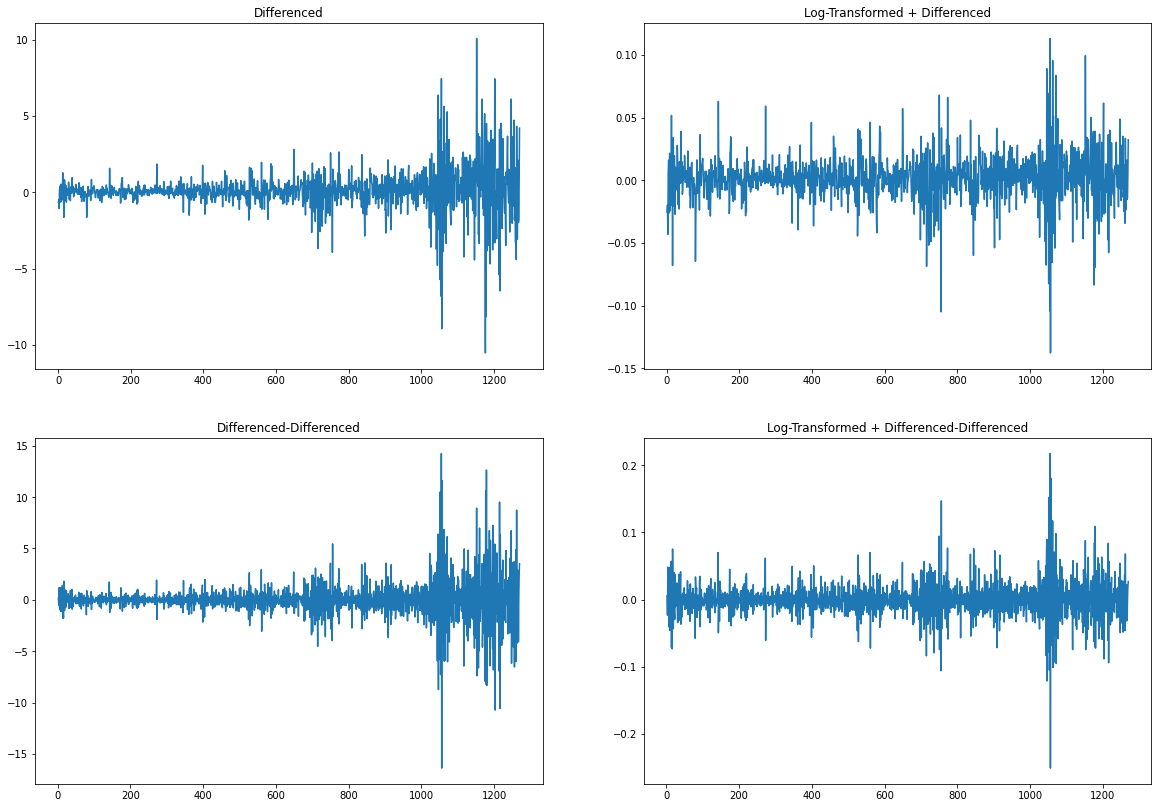

In [19]:
train_d = train.diff()
train_l_d = np.log(train).diff()
train_d_d = train.diff().diff()
train_l_d_d = np.log(train).diff().diff()

fig, ax = plt.subplots(2, 2, figsize=(20,14)) # (width, height)
sns.lineplot(data=train_d, x=train_d.index, y=train_d.values, ax=ax[0, 0]);
ax[0, 0].set_title("Differenced")
sns.lineplot(data=train_l_d, x=train_l_d.index, y=train_l_d.values, ax=ax[0, 1]);
ax[0, 1].set_title("Log-Transformed + Differenced")
sns.lineplot(data=train_d_d, x=train_d_d.index, y=train_d_d.values, ax=ax[1, 0]);
ax[1, 0].set_title("Differenced-Differenced")
sns.lineplot(data=train_l_d_d, x=train_l_d_d.index, y=train_l_d_d.values, ax=ax[1, 1]);
ax[1, 1].set_title("Log-Transformed + Differenced-Differenced");

For the plots on the left the series has constant mean, however, it does have changing variance. For the plots on the right I applied a log transformation in which we can see the series now resembles more constant variance, except for a few unusual spikes hear and there which is to be expected. 

From this point on, we'll take just the log transformed data and assume it's stationary.

To determine the parameters p and q we'll now look at the pacf and acf plots respectively.

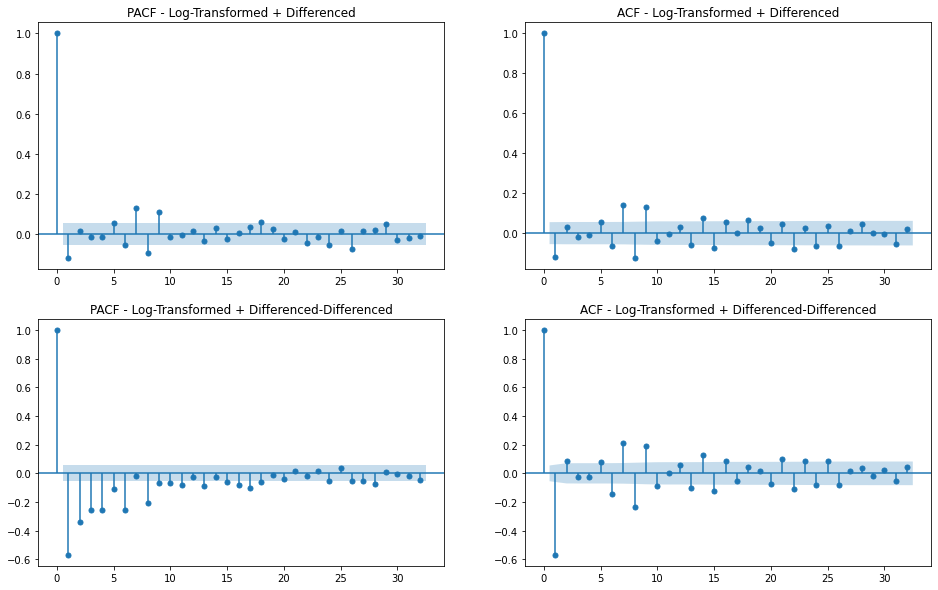

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(16,10))
plot_pacf(train_l_d.dropna(), title="PACF - Log-Transformed + Differenced", ax=ax[0, 0])
plot_acf(train_l_d.dropna(), title="ACF - Log-Transformed + Differenced",ax=ax[0, 1])
plot_pacf(train_l_d_d.dropna(), title="PACF - Log-Transformed + Differenced-Differenced",ax=ax[1, 0])
plot_acf(train_l_d_d.dropna(), title="ACF - Log-Transformed + Differenced-Differenced",ax=ax[1, 1])
plt.show()

For a stationary time series, the ACF will drop to zero relatively quickly (see: https://otexts.com/fpp2/stationarity.html) which the top-right graph depicts. Same can be said for the PACF plot on the top-left. However, the the 2 bottom plots, it looks like we have over differenced as the lollipops at lag 1 have by passed 0 becoming much more negative. 

Also, on both top-plots we see at lag 1 both lollipops are above the 95% confidence interval before dropping below it at lag 2. For this reason we'll take p = q = 1. We'll now compare to arima models with d=1 and d=2:

In [21]:
# Building ARIMA model with log transformed data having parameters p = d = q = 1
model = ARIMA(np.log(train), order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1270
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3236.517
Method:                       css-mle   S.D. of innovations              0.019
Date:                Fri, 16 Apr 2021   AIC                          -6465.035
Time:                        00:10:27   BIC                          -6444.448
Sample:                             1   HQIC                         -6457.301
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.000      2.634      0.008       0.000       0.002
ar.L1.D.Close    -0.2631      0.217     -1.211      0.226      -0.689       0.163
ma.L1.D.Close     0.1457      0.223     

In [22]:
# Building same model with 2 differences.
model2 = ARIMA(np.log(train), order=(1,2,1))
model_fit2 = model2.fit(disp=0)
print(model_fit2.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                 1269
Model:                 ARIMA(1, 2, 1)   Log Likelihood                3230.422
Method:                       css-mle   S.D. of innovations              0.019
Date:                Fri, 16 Apr 2021   AIC                          -6452.844
Time:                        00:10:27   BIC                          -6432.260
Sample:                             2   HQIC                         -6445.112
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.653e-06   1.29e-06      1.278      0.201   -8.82e-07    4.19e-06
ar.L1.D2.Close    -0.1199      0.028     -4.297      0.000      -0.175      -0.065
ma.L1.D2.Close    -1.0000      0.002

The better model is the one with the lower AIC value and that is the first model with a differencing of 1. The p-values for both the AR and MA coefficients for the first model are not signficiant at a threshold alpha level of 5%, only the constant term is. On the other hand, the second model with two differences is actually the complete opposite with both the AR and MA coefficients being significant except the constant term. 

Let's plot the residual errors of both arima models:

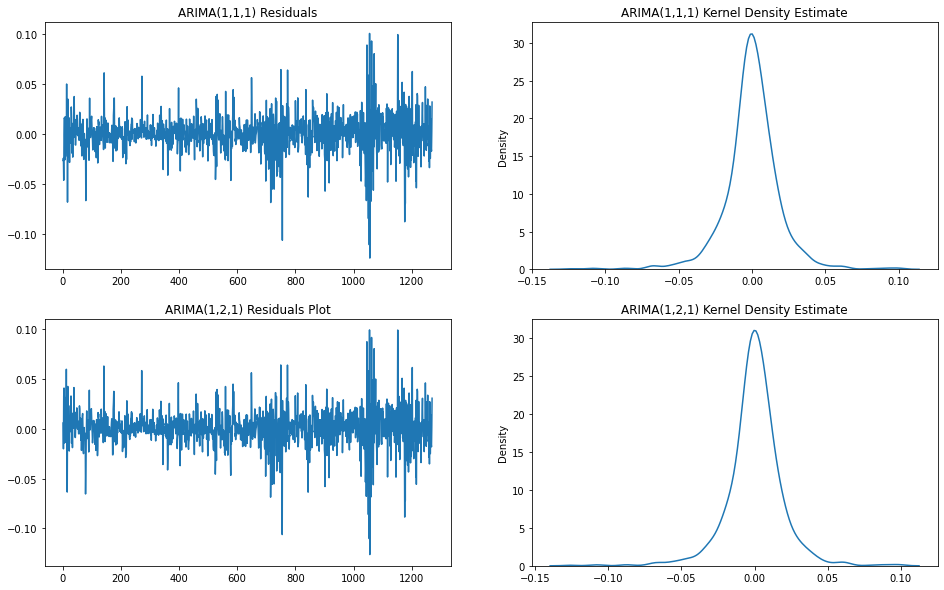

In [23]:
# Plot of the residual erros
resids1 = model_fit.resid
resids2 = model_fit2.resid

fig, ax = plt.subplots(2, 2, figsize=(16,10))
sns.lineplot(data=resids1, x=resids1.index, y=resids1.values, ax=ax[0, 0]);
ax[0, 0].set_title("ARIMA(1,1,1) Residuals")
sns.kdeplot(data=resids1, x=resids1.values, ax=ax[0, 1]);
ax[0, 1].set_title("ARIMA(1,1,1) Kernel Density Estimate")
sns.lineplot(data=resids2, x=resids2.index, y=resids2.values, ax=ax[1, 0]);
ax[1, 0].set_title("ARIMA(1,2,1) Residuals Plot")
sns.kdeplot(data=resids2, x=resids2.values, ax=ax[1, 1]);
ax[1, 1].set_title("ARIMA(1,2,1) Kernel Density Estimate");

The residuals for both the ARIMA(1,1,1) and ARIMA(1,2,1) models have mean that fluctatuate around 0. The variance is not completely constant and does fluctuate a little due to certain periods with spikes. We can also see that while the kernel density estimate plots for both models look uniform you can infact see that both are left (or negative) skewed. Though, we won't let this deter us from proceeding to making predictions. 

Let's now make predictions:

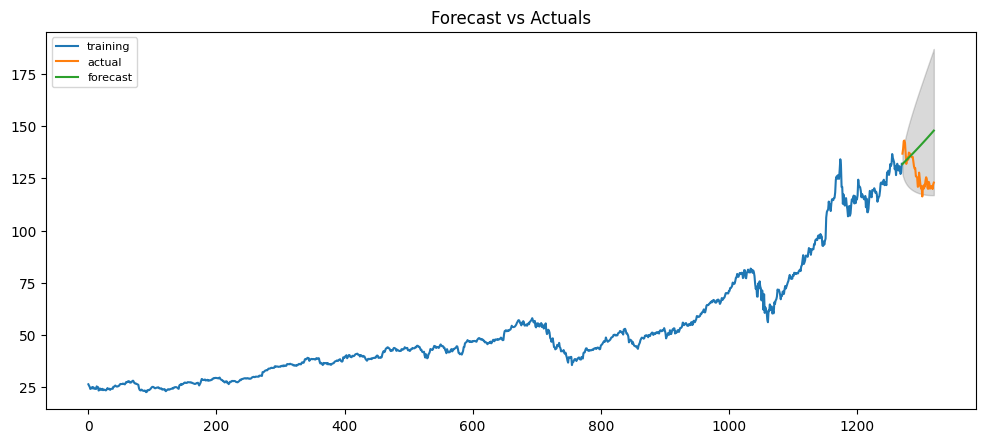

In [24]:
# Making Predictions on testing set
# model = ARIMA(train, order=(1,1,1))  
model = ARIMA(np.log(train), order=(1, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(50, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index).apply(lambda x: math.exp(x))
lower_series = pd.Series(conf[:, 0], index=test.index).apply(lambda x: math.exp(x))
upper_series = pd.Series(conf[:, 1], index=test.index).apply(lambda x: math.exp(x))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Clearly, since the ARIMA model is linear in nature we can see quite a deviation from the actual result compared to the predicted result. The predicted values are saying the stock price will increase linearly across the next 50 trading days, however, the actual values were much the opposite.

<h3>Auto-ARIMA</h3>

The auto arima model in the pmdarima package automates the previous steps for us by selecting the best model with the lowest AIC value (i.e. the most negative AIC value).

In [25]:
auto_arima = pm.auto_arima(np.log(train),
                           start_p=1,
                           max_p=4,
                           start_q=1,
                           max_q=4,
                           test="adf",
                           d=None,
                           seasonal=False,
                           trace=True,
                           suppress_warnings=True,
                           error_action="ignore")
print(auto_arima.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-6465.029, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6450.428, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6466.669, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6465.953, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6446.809, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-6464.970, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6475.826, Time=0.69 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6461.283, Time=0.30 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6460.885, Time=0.63 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6472.777, Time=0.77 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-6463.236, Time=0.13 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6459.296, Time=0.73 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-6457.734, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 4.211 seconds
         

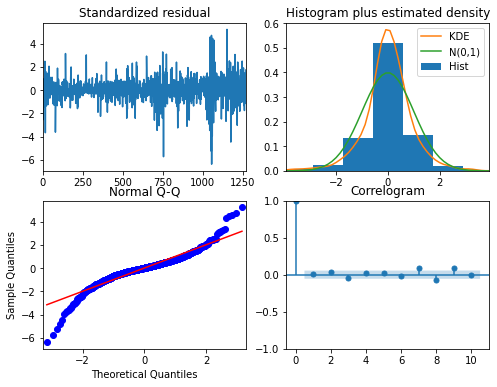

In [26]:
auto_arima.plot_diagnostics(figsize=(8,6));

Interpretation of Plots:

* Top-Left
  * We want to see the residual errors fluctuate around mean 0, which they do, and have uniform variance, which they tend not to do due to a few spikes occurring here and there, however, its stock prices so you must expect this.
* Top-Right
  * Plots histogram of residual errors along with an estimated density and a standard normal curve for reference. In our case, the kernel density estimate (KDE) differs slightly from a standard normal curve with smaller variance.
* Bottom-Right
  * Displays a ACF plot where we want to see the lollipops from lag 1 onwards be as close to 0 (or below the 95% CI) as possible, which is the case here. This means there is no autocorrelation in the residual errors. If there were autocorrelation, then there would be some sort of pattern/trend in the residual errors not explained by the model. 
* Bottom-Left
  * If all blue points fall exactly on the red line then we can say the model is normally distributed, however, in our case the blue points curve off in the tails (or extremities). This means the data have more extreme values than expected by a normal distribution.
  
The parameters arn't the best fit for the model, however, they'll do. Let's see how this model goes at forecasting: 

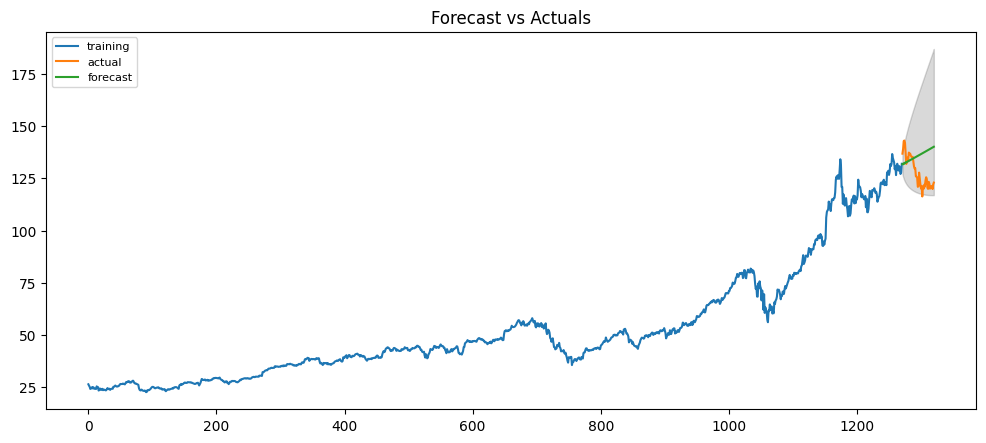

In [27]:
# Forecast
fc1, conf1 = auto_arima.predict(n_periods=50, return_conf_int=True)

# Make as pandas series
fc_series1 = pd.Series(fc1, index=test.index).apply(lambda x: math.exp(x))
lower_series1 = pd.Series(conf[:, 0], index=test.index).apply(lambda x: math.exp(x))
upper_series1 = pd.Series(conf[:, 1], index=test.index).apply(lambda x: math.exp(x))

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series1, label='forecast')
plt.fill_between(lower_series1.index, lower_series1, upper_series1, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Again, due to the linear nature of the ARIMA model, the forecasting isn't precise since the actual values are more decreasing rather than increasing.

<h3>Simple Exponential Smoothing (SES)</h3>

Component form for SES:
$$
\text{Forecast Equation:} \quad \hat{y}_{t+h|t} = l_{t} \\
\text{Smoothing Equation:} \quad l_{t} = \alpha y_{t} + (1 - \alpha)l_{t-1}
$$

where 

  * $l_{t}$ is the level (or smoothed value) of the series at time t
  * Setting $h = 1$ gives fitted values
  * Setting $t = T$ gives the forecasts beyond the training data
  * $\alpha \in [0, 1]$ is the smoothing parameter
  
In setting the model up to begin with, we need to initalize (or select) the values $\alpha$ and $l_{0}$. To do that we simply apply an optimisation problem in mininsing the SSE (sum of squared error) given by:
$$
SSE = \sum_{t=1}^{T}(y_{t} - \hat{y}_{t|t-1})^2 = \sum_{t=1}^{T}e_{t}^2
$$

SES has a flat forecast function:
$$
\hat{y}_{T+h|T} = \hat{y}_{T+1|T} = l_{t}, \quad h = 2, 3, ...
$$

Note: We should only use SES is there is no trend or seasonal component, but we demonstrate below.

Referenced from: https://otexts.com/fpp2/ses.html

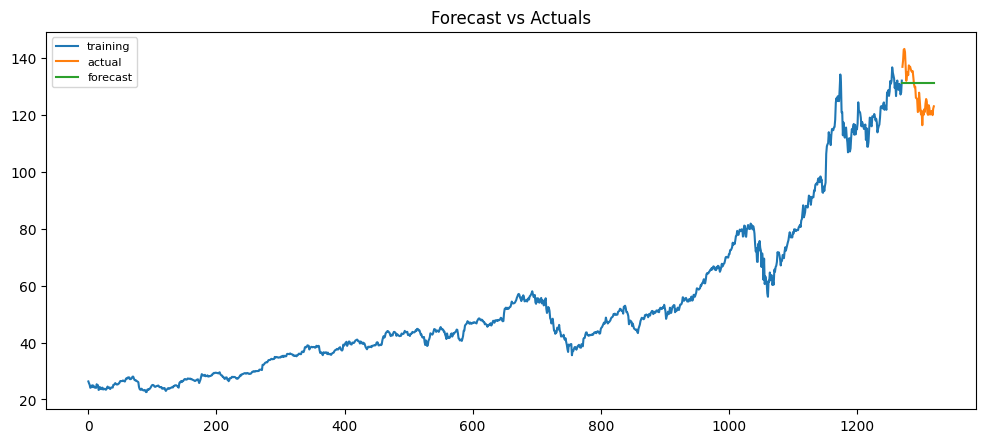

In [28]:
# Create Simple Exponential Smoothing Model
model_ses = SimpleExpSmoothing(np.array(train))

# Fit and get predictions
fit_ses = model_ses.fit(smoothing_level=0.8)
pred_ses = pd.Series(fit_ses.forecast(50), index=test.index)

# Plot predictions
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(pred_ses, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

<h3>Holt's Method</h3>

For the first model the formula given by:
$$
\text{Forecast equation:} \quad \hat{y}_{t+h|t} = l_{t} + hb_{t} \\
\text{Level equation:} \quad l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1} + b_{t-1}) \\
\text{Trend equation:} \quad b_{t} = \beta^{*}(l_{t} - l_{t-1}) + (1 - \beta^{*})b_{t-1} \\
$$
where 

  * $l_{t}$ denotes an estimate of the level of the series at time t
  * $b_{t}$ denotes estimate of trend (slope) of series at time t
  * $\alpha \in [0, 1]$ is the smoothing parameter for level
  * $\beta^{*} \in [0, 1]$ is the smoothing parameter for the trend 
   
For the second model formula is:
$$
\text{Forecast equation:} \quad \hat{y}_{t} = l_{t-1} + \phi b_{t-1} + \epsilon_{t} \\
\text{Level equation:} \quad l_{t} = l_{t-1} + b_{t-1} + \alpha \epsilon_{t}\\
\text{Trend equation:} \quad b_{t} = \phi b_{t-1} + \beta \epsilon_{t} \\
$$
where 

  * $\epsilon_{t} \sim NID(0, \sigma^2)$
  
For the third model formula is:
$$
\text{Forecast equation:} \quad \hat{y}_{t+h|t} = l_{t} + (\phi + \phi^{2} + ... + \phi^{h})b_{t} \\
\text{Level equation:} \quad l_{t} = \alpha y_{t} + (1 - \alpha)(l_{t-1} + \phi b_{t-1}) \\
\text{Trend equation:} \quad b_{t} = \beta^{*}(l_{t} - l_{t-1}) + (1 - \beta^{*})\phi b_{t-1} \\
$$
where 

  * $\phi \in (0, 1)$ dampens trend so it approaches a constant some time in future. 
    * If $\phi = 1$ then the model is equivalent to the first model
    * Restrict $\phi \in [0.8, 0.98]$ as dampening has strong effect for smaller values.
    
Referenced from: https://otexts.com/fpp2/holt.html, https://otexts.com/fpp2/taxonomy.html

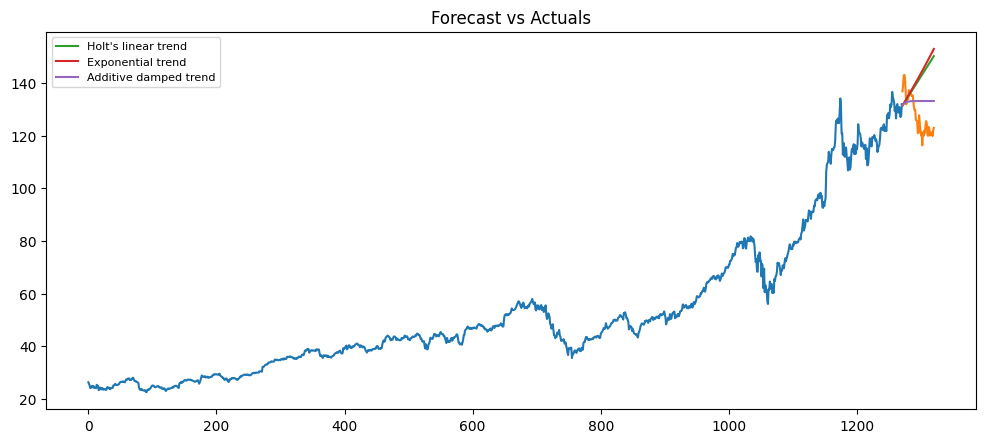

In [29]:
fit_h_1 = Holt(train, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
fit_h_2 = Holt(train, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=False)
fit_h_3 = Holt(train, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2)

fit_cast_1 = fit_h_1.forecast(50).rename("Holt's linear trend")
fit_cast_2 = fit_h_2.forecast(50).rename("Exponential trend")
fit_cast_3 = fit_h_3.forecast(50).rename("Additive damped trend")

# Plot predictions
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train)
plt.plot(test)
line1, = plt.plot(fit_cast_1)
line2, = plt.plot(fit_cast_2)
line3, = plt.plot(fit_cast_3)
plt.title('Forecast vs Actuals')
plt.legend([line1, line2, line3], [fit_cast_1.name, fit_cast_2.name, fit_cast_3.name], loc='upper left', fontsize=8)
plt.show()

<h3>LSTM, RNN, GRU</h3>

In [30]:
# Make copies of data
train_lstm = train.to_frame().copy()
test_lstm = test.to_frame().copy()

In [31]:
# MinMaxScale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_lstm)
test_scaled = scaler.transform(test_lstm)

In [32]:
# Set time step as 60
x_train, y_train = [], []
for i in range(60, len(train_scaled)):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Needs to be in form: [batch, timesteps, feature]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [33]:
# LSTM Model
class lstmModel(Model):
    def __init__(self):
        super(lstmModel, self).__init__()
        self.lstm1 = LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))
        self.do1 = Dropout(0.2)
        self.lstm2 = LSTM(units=50)
        self.do2 = Dropout(0.2)
        self.dense = Dense(units=1)
    
    def call(self, x):
        x = self.lstm1(x)
        x = self.do1(x)
        x = self.lstm2(x)
        x = self.do2(x)
        return self.dense(x)

model = lstmModel()

In [34]:
# RNN Model
class RNNModel(Model):
    def __init__(self):
        super(RNNModel, self).__init__()
        self.rnn1 = SimpleRNN(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))
        self.do1 = Dropout(0.2)
        self.rnn2 = SimpleRNN(units=50)
        self.do2 = Dropout(0.2)
        self.dense = Dense(units=1)
    
    def call(self, x):
        x = self.rnn1(x)
        x = self.do1(x)
        x = self.rnn2(x)
        x = self.do2(x)
        return self.dense(x)

model_RNN = RNNModel()

In [35]:
# GRU Model
class GRUModel(Model):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.gru1 = GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))
        self.do1 = Dropout(0.2)
        self.gru2 = GRU(units=50)
        self.do2 = Dropout(0.2)
        self.dense = Dense(units=1)
    
    def call(self, x):
        x = self.gru1(x)
        x = self.do1(x)
        x = self.gru2(x)
        x = self.do2(x)
        return self.dense(x)

model_GRU = GRUModel()

In [36]:
# LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
38/38 [==============================] - 3s 24ms/step - loss: 0.0489
Epoch 2/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0025
Epoch 3/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0020
Epoch 4/25
38/38 [==============================] - 1s 25ms/step - loss: 0.0024
Epoch 5/25
38/38 [==============================] - 1s 22ms/step - loss: 0.0017
Epoch 6/25
38/38 [==============================] - 1s 22ms/step - loss: 0.0013
Epoch 7/25
38/38 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 8/25
38/38 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 9/25
38/38 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 10/25
38/38 [==============================] - 1s 21ms/step - loss: 0.0017
Epoch 11/25
38/38 [==============================] - 1s 21ms/step - loss: 0.0020
Epoch 12/25
38/38 [==============================] - 1s 22ms/step - loss: 0.0020
Epoch 13/25
38/38 [==================

In [37]:
# RNN Model
model_RNN.compile(optimizer='adam', loss='mean_squared_error')
model_RNN.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
38/38 [==============================] - 1s 12ms/step - loss: 0.1101
Epoch 2/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0222
Epoch 3/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0136
Epoch 4/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0140
Epoch 5/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0105
Epoch 6/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0073
Epoch 7/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0063
Epoch 8/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0065
Epoch 9/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0043
Epoch 10/25
38/38 [==============================] - 0s 12ms/step - loss: 0.0037
Epoch 11/25
38/38 [==============================] - 0s 13ms/step - loss: 0.0040
Epoch 12/25
38/38 [==============================] - 1s 13ms/step - loss: 0.0035
Epoch 13/25
38/38 [==================

In [38]:
# GRU Model
model_GRU.compile(optimizer='adam', loss='mean_squared_error')
model_GRU.fit(x_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
38/38 [==============================] - 2s 24ms/step - loss: 0.0228
Epoch 2/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0021
Epoch 3/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0017
Epoch 4/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0019
Epoch 5/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0014
Epoch 6/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 7/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 8/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 9/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0014
Epoch 10/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 11/25
38/38 [==============================] - 1s 23ms/step - loss: 0.0012
Epoch 12/25
38/38 [==============================] - 1s 23ms/step - loss: 9.6193e-04
Epoch 13/25
38/38 [==============

In [39]:
# Predicting
whole_dataset = np.append(train_scaled, test_scaled)
inputs = whole_dataset[len(whole_dataset) - len(test_scaled) - 60:].reshape(-1,1) # already been scaled

x_test = []
for i in range(60, inputs.shape[0]):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

preds_lstm = model.predict(x_test)
preds_lstm = scaler.inverse_transform(preds_lstm)

preds_rnn = model_RNN.predict(x_test)
preds_rnn = scaler.inverse_transform(preds_rnn)

preds_gru = model_GRU.predict(x_test)
preds_gru = scaler.inverse_transform(preds_gru)

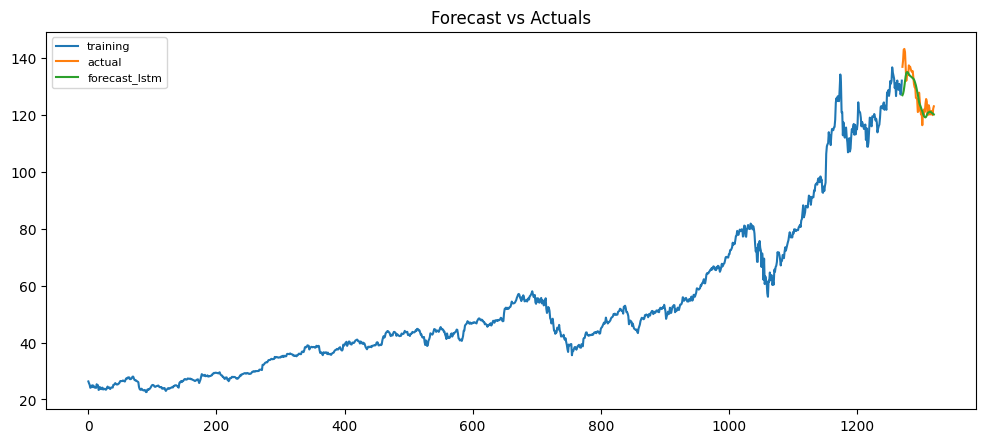

In [40]:
test_lstm1 = test_lstm.copy()
test_lstm1['preds_lstm'] = preds_lstm
test_lstm1['preds_rnn'] = preds_rnn
test_lstm1['preds_gru'] = preds_gru

# Plot predictions
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_lstm.Close, label='training')
plt.plot(test_lstm1.Close, label='actual')
plt.plot(test_lstm1.preds_lstm, label='forecast_lstm')
# plt.plot(test_lstm1.preds_rnn, label='forecast_rnn') # uncomment and try
# plt.plot(test_lstm1.preds_gru, label='forecast_gru') # uncomment and try
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can see the LSTM model resembles the stock price quite well as compared to the other models. We can see the green forecasted line follows the same trend/pattern as the actuals. Try commenting out the LSTM and seeing how the RNN and GRU predictions go in the above graph.

It should be noted, however, that in reality you wouldn't set aside a testing dataset based on the past 60 days of stock prices. The reason being is that we want to form a prediction on tomorrows stock, which is unknown today, so we'd need to use all the given data, that is the training and testing sets, as the training set. The only downfall with this type of approach is that you'd need to train the model each day as of closing (or before next days trading, or throughout the trading day). Though, this can get tedious training the model quite often, I'm sure this process can be automated.

Also, it should be worth mentioning that if you want to make predictions of the stock prices for say the next 10 trading days, what you could do iteratively is use the latest 60 days of stock prices to form a prediction for tomorrow, then using the models prediction for tomorrow along with the latest 59 days of stock prices is to form a prediction for the day after the tomorrow, then you could use the two model predictions for tomorrow and the following day along with the latest 58 days to form a prediction for the third day and so on. Obviously, I wouldn't recommend doing this since the degree of accuracy will decrease each time you use a models prediction to form a prediction for the next day in the future.

<h1 style="color:rgba(246,57,23,0.8);text-align:center"><u>Final Thoughts</u></h1>

What we covered was a variety of different algorithms that may be useful in predicting the price of a stock. Each of the different algorithms has its advantages and disadvantages, but, there is one underlying factor that you can't deny and that is the stock market is unpredictable. Take a look at the college basketball in America back in Feburary 2019 where Nike lost more than \$2billion off its market value due to Zion Williamson's pair of Nike trainer's breaking. These things you just don't hear of, so you must embrace for the worst at times as your model can not possibly predict such a circumstance. 

Though it should be worth noting that as models may help to assist in predicting the share price, ultimately, it comes down to supply and demand. For example, if investors see potential in a company then more than likely the share price will rise, however, if investors see the company's been in the news for the wrong thing then you can expect the share price to slide. 